In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import plotly.express as px
from sklearn.metrics import recall_score, roc_auc_score, average_precision_score, fbeta_score, precision_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import optuna
import optuna.visualization as vis
import shap

In [2]:
train_data_path = Path('.').resolve().parent / 'data' / 'fraudTrain.csv'
test_data_path = Path('.').resolve().parent / 'data' / 'fraudTest.csv'

train_data = pd.read_csv(train_data_path, index_col=0)
test_data = pd.read_csv(test_data_path, index_col=0)

pre process from baseline modeling:

In [3]:
dict_assign = {
    "trans_date_trans_time": pd.to_datetime(train_data['trans_date_trans_time'], yearfirst=True),
    "yob": pd.to_datetime(train_data['dob'], yearfirst=True).dt.year,
}

train_data = train_data.assign(**dict_assign)

dict_assign = {
    "trans_date_trans_time": pd.to_datetime(test_data['trans_date_trans_time'], yearfirst=True),
    "yob": pd.to_datetime(test_data['dob'], yearfirst=True).dt.year
}

test_data = test_data.assign(**dict_assign)

# Feature Engineering

#### trans_date_trans_time

In [4]:
dict_assign = {
    "trans_date_trans_time_month": train_data['trans_date_trans_time'].dt.month,
    "trans_date_trans_time_weekday": train_data['trans_date_trans_time'].dt.weekday,
}

train_data = train_data.assign(**dict_assign)

dict_assign = {
    "trans_date_trans_time_month": test_data['trans_date_trans_time'].dt.month,
    "trans_date_trans_time_weekday": test_data['trans_date_trans_time'].dt.weekday,
}

test_data = test_data.assign(**dict_assign)

#### street

In [5]:
n_top_streets = 200

top_streets = train_data['street'].value_counts(normalize=True).iloc[:n_top_streets].index

dict_assign = {
    "is_top_street": train_data['street'].apply(lambda x: True if x in top_streets else False),
}

train_data = train_data.assign(**dict_assign)

dict_assign = {
    "is_top_street": test_data['street'].apply(lambda x: True if x in top_streets else False),  # DON'T CHANGE THE top_streets variable (should consider only train data streets)
}

test_data = test_data.assign(**dict_assign)

#### job

In [6]:
n_top_jobs = 200

top_jobs = train_data['job'].value_counts(normalize=True).iloc[:n_top_jobs].index

dict_assign = {
    "is_top_job": train_data['job'].apply(lambda x: True if x in top_jobs else False),
}

train_data = train_data.assign(**dict_assign)

dict_assign = {
    "is_top_job": test_data['job'].apply(lambda x: True if x in top_jobs else False),  # DON'T CHANGE THE top_jobs variable (should consider only train data jobs)
}

test_data = test_data.assign(**dict_assign)

#### city

In [7]:
n_top_cities = 200

top_cities = train_data['city'].value_counts(normalize=True).iloc[:n_top_cities].index

dict_assign = {
    "is_top_city": train_data['city'].apply(lambda x: True if x in top_cities else False),
}

train_data = train_data.assign(**dict_assign)

dict_assign = {
    "is_top_city": test_data['city'].apply(lambda x: True if x in top_cities else False),  # DON'T CHANGE THE top_cities variable (should consider only train data cities)
}

test_data = test_data.assign(**dict_assign)

#### zip

In [8]:
train_data['zip']

0          28654
1          99160
2          83252
3          59632
4          24433
           ...  
1296670    84735
1296671    21790
1296672    88325
1296673    57756
1296674    59871
Name: zip, Length: 1296675, dtype: int64

# Modeling with new features

**features**:

- category -> one hot encoding / partition-based split
- amt
- gender -> one hot encoding / partition-based split
- state -> one hot encoding / partition-based split
- zip
- lat
- long
- city_pop
- dob -> get year of birth (yob)
- merch_lat
- merch_long
- trans_date_trans_time_weekday
- trans_date_trans_time_month
- is_top_city
- is_top_job
- is_top_street

**metrics**: target -> custom f3score (recovered_fraud_percent_amt 3 times more important than precision); other metrics to watch ->  recall / precision / %predicted_positives / aucPR / aucROC / recovered_fraud_percent_amt

**class imbalance**: balance with oversampling the minority class (copy the positive class N times)

In [9]:
def recovered_fraud_percent_amt(y_true, y_pred, transaction_amount):
    # return the percentage of fraud amount the model recovered
    # y_true: true labels (1 for fraud, 0 for not fraud)
    # y_pred: predicted labels (1 for fraud, 0 for not fraud)
    # transaction_amount: the amount of each transaction
    if (len(y_true) != len(y_pred)) or (len(y_true) != len(transaction_amount)):
        raise ValueError("y_true, y_pred, and transaction_amount must have the same length")
    
    total_fraud_amount = (y_true * transaction_amount).sum()
    if total_fraud_amount == 0:
        return 0.0
    fraud_amount_recovered = (y_true * transaction_amount * y_pred).sum()
    return fraud_amount_recovered / total_fraud_amount

def custom_fbeta_score(y_true, y_pred, transaction_amount, beta=1.0):
    # calculate the custom F-beta score as a harmonic mean of recovered_fraud_percent_amt and precision
    if (len(y_true) != len(y_pred)):
        raise ValueError("y_true and y_pred must have the same length")
    recovered_fraud = recovered_fraud_percent_amt(y_true, y_pred, transaction_amount=transaction_amount)
    precision = precision_score(y_true, y_pred, zero_division=0)
    if (recovered_fraud + precision) == 0:
        return 0.0
    return (1 + beta**2) * (recovered_fraud * precision) / ((beta**2 * precision) + recovered_fraud)


def balance_train_data(factor_balance, X_train, y_train):
    X_train_balanced = pd.concat([
        X_train,
        pd.concat([X_train.loc[y_train[y_train == 1].index] for _ in range(factor_balance)], axis=0)
        ], axis=0
    )

    y_train_balanced = pd.concat([
        y_train,
        pd.concat([y_train.loc[y_train[y_train == 1].index] for _ in range(factor_balance)], axis=0)
        ], axis=0
    )
    
    return X_train_balanced, y_train_balanced

def evaluate_all_metrics(model, X_test, y_test, fscore_beta):
    print("custom_fbeta_score", str(round(custom_fbeta_score(y_true=y_test, y_pred=model.predict(X_test), transaction_amount=X_test['amt'], beta=fscore_beta) * 100, 2)) + "%")
    print("recovered_fraud_percent_amt", str(round(recovered_fraud_percent_amt(y_true=y_test, y_pred=model.predict(X_test), transaction_amount=X_test['amt']) * 100, 2)) + "%")
    print("recall:", str(round(recall_score(y_pred=model.predict(X_test), y_true=y_test) * 100, 2)) + "%")
    print("precision:", str(round(precision_score(y_pred=model.predict(X_test), y_true=y_test) * 100, 2)) + "%")
    print("Percent of predicted as positives:", str(round(model.predict(X_test).mean() * 100, 2) ) + "%")
    print("fbeta:", str(round(fbeta_score(y_pred=model.predict(X_test), y_true=y_test, beta=fscore_beta) * 100, 2)) + "%")
    print("roc_auc_score", str(round(roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:, 1]) * 100, 2)) + "%")
    print("average_precision_score", str(round(average_precision_score(y_true=y_test, y_score=model.predict_proba(X_test)[:, 1]) * 100, 2)) + "%")

def fraud_ev(y_true, y_score, transaction_amount):
    # TODO: implement the fraud expected value function
    pass

In [10]:
numerical_features = ['amt', 'zip', 'lat', 'long', 'city_pop', 'yob', 'merch_lat', 'merch_long', 'trans_date_trans_time_month', 'trans_date_trans_time_weekday']
categorical_features = ['category', 'gender', 'state', 'is_top_street', 'is_top_job', 'is_top_city']

# transform the categorical features to 'category' dtype
X_train = train_data[categorical_features].astype('category').join(train_data[numerical_features])
y_train = train_data['is_fraud']
X_test = test_data[categorical_features].astype('category').join(test_data[numerical_features])
y_test = test_data['is_fraud']

### without best params search:
meant to be simple

In [11]:
factor_balance = 170  # to balance 50/50
fscore_beta = 3  # using beta=3 for higher recall influence

X_train_balanced, y_train_balanced = balance_train_data(factor_balance=factor_balance, X_train=X_train, y_train=y_train)

y_train_balanced.value_counts(normalize=True) * 100

is_fraud
0    50.109671
1    49.890329
Name: proportion, dtype: float64

In [12]:
model = XGBClassifier(enable_categorical=True, random_state=0, device='cuda')
model.fit(X_train_balanced, y_train_balanced)
# evaluate on test data:
evaluate_all_metrics(model, X_test, y_test, fscore_beta)

/home/lucas/.pyenv/versions/credit-card-fraud-detection-venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [09:37:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


custom_fbeta_score 73.89%
recovered_fraud_percent_amt 88.51%
recall: 80.23%
precision: 29.71%
Percent of predicted as positives: 1.04%
fbeta: 68.57%
roc_auc_score 98.95%
average_precision_score 69.13%


### with best params search:
more complex and more compute

In [13]:
cv_n_splits = 10
n_trials = 100
n_jobs = 3  # number of parallel jobs for Optuna

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.6),
        'n_estimators': trial.suggest_int('n_estimators', 20, 600),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'enable_categorical': True,
        'random_state': 0,
        'device': 'cuda',
    }
    
    factor_balance = trial.suggest_int('factor_balance', 1, 170)  # balance factor for training data
    
    # initializing the XGBoost model
    model = XGBClassifier(**param)
    cv = StratifiedKFold(n_splits=cv_n_splits, shuffle=False)

    cv_scores = []
    for train_index, test_index in cv.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # balance the training data for each fold
        X_train_fold_balanced, y_train_fold_balanced = balance_train_data(factor_balance=factor_balance, X_train=X_train_fold, y_train=y_train_fold)
        
        model.fit(X_train_fold_balanced, y_train_fold_balanced)
        y_pred = model.predict(X_test_fold)
        # cv_scores.append(fbeta_score(y_pred=y_pred, y_true=y_test_fold, beta=fscore_beta))
        # cv_scores.append(recovered_fraud_percent_amt(y_pred=y_pred, y_true=y_test_fold, transaction_amount=X_test_fold['amt']))
        cv_scores.append(custom_fbeta_score(y_true=y_test_fold, y_pred=y_pred, transaction_amount=X_test_fold['amt'], beta=fscore_beta))
    
    score = np.mean(cv_scores)  # calculating score using cross-validation
    return score

study = optuna.create_study(study_name="baseline_study", direction='maximize') 
study.optimize(objective, n_trials=n_trials, show_progress_bar=True, n_jobs=n_jobs)   

# Retrieve the best parameter values
best_params = study.best_params
print(f"\nBest parameters: {best_params}")

[I 2025-08-02 09:37:05,656] A new study created in memory with name: baseline_study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-02 09:38:18,696] Trial 2 finished with value: 0.6576131410662706 and parameters: {'max_depth': 9, 'learning_rate': 0.05921268042766012, 'n_estimators': 55, 'subsample': 0.7497441809467204, 'colsample_bytree': 0.9482664435772429, 'factor_balance': 144}. Best is trial 2 with value: 0.6576131410662706.
[I 2025-08-02 09:38:52,994] Trial 1 finished with value: 0.6129009137723046 and parameters: {'max_depth': 2, 'learning_rate': 0.06281548044239732, 'n_estimators': 415, 'subsample': 0.941801507654067, 'colsample_bytree': 0.9153447890987094, 'factor_balance': 129}. Best is trial 2 with value: 0.6576131410662706.
[I 2025-08-02 09:39:30,734] Trial 3 finished with value: 0.6345600217473091 and parameters: {'max_depth': 7, 'learning_rate': 0.30883513920778677, 'n_estimators': 93, 'subsample': 0.7209687843802778, 'colsample_bytree': 0.8520168288084184, 'factor_balance': 167}. Best is trial 2 with value: 0.6576131410662706.
[I 2025-08-02 09:41:52,466] Trial 0 finished with value: 0.46939

In [14]:
display(vis.plot_param_importances(study))
display(vis.plot_optimization_history(study))

evaluate on test data:

In [15]:
X_train_balanced, y_train_balanced = balance_train_data(factor_balance=best_params['factor_balance'], X_train=X_train, y_train=y_train)

model = XGBClassifier(**best_params, enable_categorical=True, random_state=0, device='cuda')
model.fit(X_train_balanced, y_train_balanced)

/home/lucas/.pyenv/versions/credit-card-fraud-detection-venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning:

[10:37:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "factor_balance" } are not used.




,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8098836006405035
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [16]:
evaluate_all_metrics(model, X_test, y_test, fscore_beta)

custom_fbeta_score 86.14%
recovered_fraud_percent_amt 97.82%
recall: 81.86%
precision: 41.52%
Percent of predicted as positives: 0.76%
fbeta: 74.62%
roc_auc_score 99.15%
average_precision_score 67.7%


# Model Explainability

In [22]:
shap.initjs()
explainer = shap.Explainer(model, feature_perturbation='interventional')
shap_values = explainer(X_train_balanced, check_additivity=False)

/home/lucas/.pyenv/versions/credit-card-fraud-detection-venv/lib/python3.12/site-packages/shap/explainers/_tree.py:253: FutureWarning:

In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.



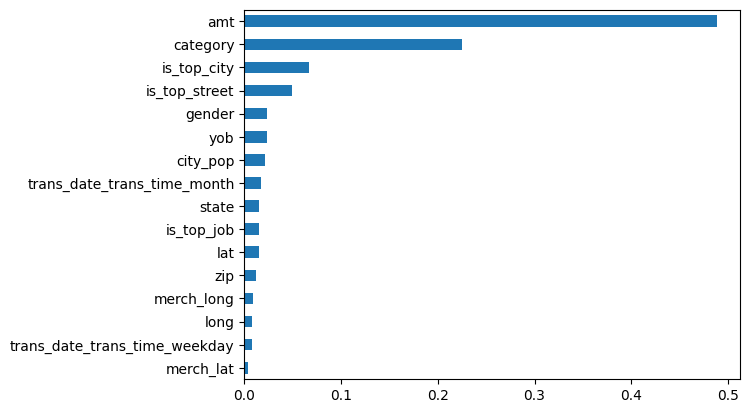

In [23]:
pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=True).plot.barh();

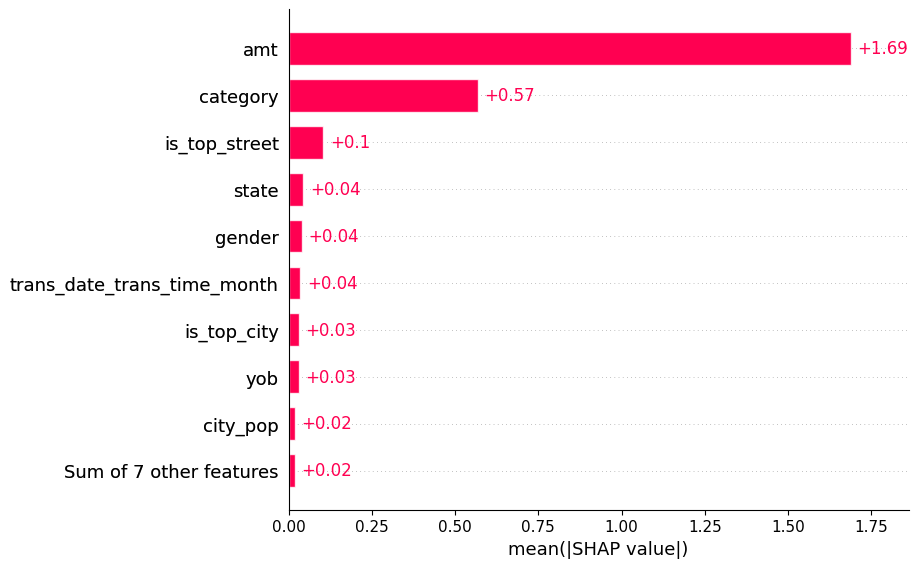

In [24]:
shap.plots.bar(shap_values)

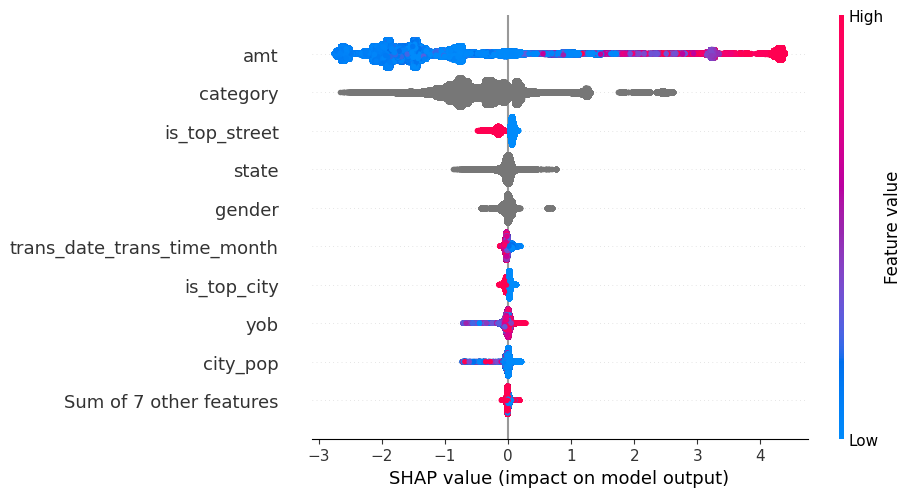

In [25]:
shap.plots.beeswarm(shap_values)

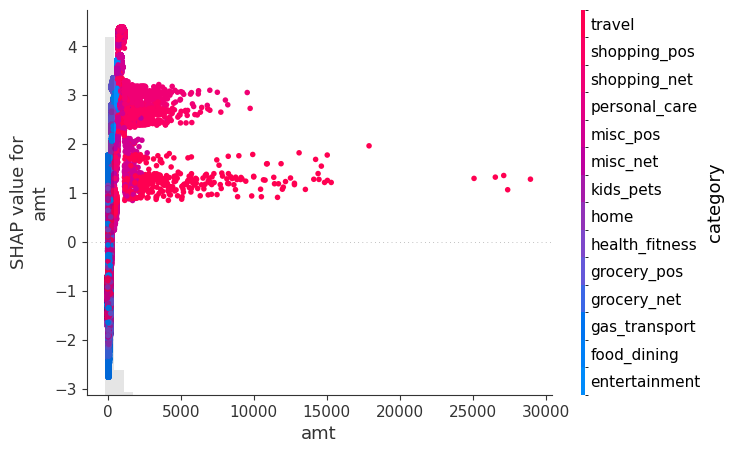

In [26]:
shap.plots.scatter(shap_values[:, "amt"], color=shap_values)

# Next steps

ideas for feature engineering:
- trans_date_trans_time have a pattern -> create features to capture that
- street -> near each other (aggregate)
- zip -> near each other (aggregate)



idea for modeling -> consider time dependent frauds (time series split)


consider other types of models / use probability / consider neural network with custom loss function